# Titnic Survival Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Global Variables

In [2]:
import easydict
args = easydict.EasyDict()     # Dict --- args 딕셔너리형이다. 들고다니기 편해서 실제로 easydict.EasyDict() 많이 씀

In [3]:
# path 정보
args.default_path = 'C:/titanic_datas/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"    
                    # 아래 args.results = [] 결과부분을 제이슨 형태로 저장함

# 데이터 분석을 위한 변수들
args.random_state = 21   # random_state = seed값 설정
args.results=[]

# Load Titanic 

- Surived : 0 = 사망, 1 = 생존
- Pclass : 1 = 1등석, 2 = 2등석, 3 = 3등석
- gender : male = 남성, female = 여성
- Age : 나이
- SibSp : 타이타닉 호에 동승한 자매/배우자의 수
- Parch : 타이타닉 호에 동승한 부모/자식의 수
- Ticket : 티켓 번호
- Fare : 승객 요금
- Cabin : 방 호수
- Embarked : 탑승지; C = 셰르부르, Q = 퀴즈타운, S = 사우샘프턴

In [4]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)VVFFFFFFFFFFFFFVV

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [5]:
ori_train.columns, ori_test.columns

(Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'),
 Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
        'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'))

In [6]:
ori_train.head() 

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [7]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [8]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [9]:
ori_test.set_index(['passengerid'], inplace=True) 
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [10]:
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [11]:
from sklearn.model_selection import train_test_split # 사이킷런

In [12]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'], random_state=args.random_state)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 10), (275, 10), (641,), (275,))

# Base ModelV0

In [14]:
train = X_tr.copy()  
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

## Data Preprocessing

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   name      641 non-null    object 
 2   gender    641 non-null    object 
 3   age       512 non-null    float64
 4   sibsp     641 non-null    int64  
 5   parch     641 non-null    int64  
 6   ticket    641 non-null    object 
 7   fare      641 non-null    float64
 8   cabin     135 non-null    object 
 9   embarked  641 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.1+ KB


drop columns

In [16]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']  

train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)
ori_te.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (641, 10) / (275, 10)
after: (641, 7) / (275, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   gender    641 non-null    object 
 2   age       512 non-null    float64
 3   sibsp     641 non-null    int64  
 4   parch     641 non-null    int64  
 5   fare      641 non-null    float64
 6   embarked  641 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 40.1+ KB


missing value

In [17]:
train.isnull().sum()  

pclass        0
gender        0
age         129
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64

In [18]:
test.isnull().sum()

pclass       0
gender       0
age         51
sibsp        0
parch        0
fare         0
embarked     1
dtype: int64

In [19]:
ori_te.isnull().sum()

pclass       0
gender       0
age         83
sibsp        0
parch        0
fare         1
embarked     1
dtype: int64

In [20]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]   # 최빈값?

age_median, fare_median, embarked_mode

(28.0, 14.4, 'S')

In [21]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

data encoding

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
train.columns

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [24]:
enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols)) 
normal_cols

['age', 'fare', 'parch', 'pclass', 'sibsp']

In [25]:
print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(),  
    columns = enc.get_feature_names_out()     
)
enc_tr = pd.concat(   
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)] 
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(),    
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')
enc_tr.head()

before: (641, 7) / (275, 7)
after: (641, 10) / (275, 10)


,age,fare,parch,pclass,sibsp,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,22.0,7.7750,0,3,0,1.0,0.0,0.0,0.0,1.0
1,21.0,7.8208,0,3,0,0.0,1.0,0.0,1.0,0.0
2,32.0,7.8542,0,3,0,0.0,1.0,0.0,0.0,1.0
3,11.0,18.7875,0,3,0,0.0,1.0,1.0,0.0,0.0
4,30.0,8.0500,0,3,0,0.0,1.0,0.0,0.0,1.0


## Training

In [26]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [27]:
enc_tr.shape, enc_te.shape, enc_ori_te.shape

((641, 10), (275, 10), (393, 10))

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
modelV0 = DecisionTreeClassifier(random_state=args.random_state)

print(f'{enc_tr.shape} / {y_tr.shape}')
modelV0.fit(enc_tr, y_tr)

(641, 10) / (641,)


DecisionTreeClassifier(random_state=21)

## Evaluation

In [30]:
score_tr = modelV0.score(enc_tr, y_tr)   
score_te = modelV0.score(enc_te, y_te) 

score_tr, score_te  

(0.982839313572543, 0.7745454545454545)

In [31]:
from sklearn.metrics import roc_curve, auc 
                    
y_pred = modelV0.predict_proba(enc_te)[:,1] 
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7635796221322538


In [32]:
ori_te_pred = modelV0.predict_proba(enc_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [33]:
modelV0.feature_importances_

array([0.17352864, 0.19704895, 0.00739608, 0.0638137 , 0.0388822 ,
       0.49297873, 0.        , 0.01206258, 0.        , 0.01428912])

In [34]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_, enc_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(10, 2)


,index,0
0,gender_female,0.492979
1,fare,0.197049
2,age,0.173529
3,pclass,0.063814
4,sibsp,0.038882
5,embarked_S,0.014289
6,embarked_C,0.012063
7,parch,0.007396
8,gender_male,0.000000
9,embarked_Q,0.000000


In [35]:
args.results.append(
    {
        'model': 'modelV0',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

args.results

[{'model': 'modelV0',
  'score_tr': 0.982839313572543,
  'score_te': 0.7745454545454545,
  'auc_te': 0.7635796221322538,
  'ori_te_pred': array([1.        , 1.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.125     , 1.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 1.        ,
         0.        , 1.        , 0.        , 0.        , 0.125     ,
         0.        , 0.        , 0.        , 0.        , 0.125     ,
         0.        , 0.        , 1.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.5       , 1.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 1.        , 1. 

# Base ModelV1

In [36]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

## Data Preprocessing

In [37]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)
ori_te.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (641, 10) / (275, 10)
after: (641, 7) / (275, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   gender    641 non-null    object 
 2   age       512 non-null    float64
 3   sibsp     641 non-null    int64  
 4   parch     641 non-null    int64  
 5   fare      641 non-null    float64
 6   embarked  641 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 40.1+ KB


In [38]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(28.0, 14.4, 'S')

In [39]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols))
normal_cols

['age', 'fare', 'parch', 'pclass', 'sibsp']

In [42]:
print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')

before: (641, 7) / (275, 7)
after: (641, 10) / (275, 10)


scaler

In [43]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [44]:
enc_tr.columns

Index(['age', 'fare', 'parch', 'pclass', 'sibsp', 'gender_female',
       'gender_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [45]:
scaling_cols = ['age', 'fare']
not_scaling_cols = list(set(enc_tr.columns) - set(scaling_cols))
not_scaling_cols 

['embarked_S',
 'gender_male',
 'embarked_Q',
 'parch',
 'gender_female',
 'pclass',
 'embarked_C',
 'sibsp']

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
std = StandardScaler()

_scaled_tr = std.fit_transform(enc_tr[scaling_cols])
_scaled_te = std.transform(enc_te[scaling_cols])
_scaled_ori_te = std.transform(enc_ori_te[scaling_cols])

In [48]:
print(f'before: {enc_tr.shape} / {enc_te.shape}')
# train
tmp_tr = pd.DataFrame(
    _scaled_tr, 
    columns = scaling_cols
)
scaled_tr = pd.concat(
    [enc_tr[not_scaling_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# test
tmp_te = pd.DataFrame(
    _scaled_te, 
    columns = scaling_cols
)
scaled_te = pd.concat(
    [enc_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# ori_test
tmp_te = pd.DataFrame(
    _scaled_ori_te, 
    columns = scaling_cols
)
scaled_ori_te = pd.concat(
    [enc_ori_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

print(f'after: {scaled_tr.shape} / {scaled_te.shape}')
scaled_tr.head()

before: (641, 10) / (275, 10)
after: (641, 10) / (275, 10)


,embarked_S,gender_male,embarked_Q,parch,gender_female,pclass,embarked_C,sibsp,age,fare
0,1.0,0.0,0.0,0,1.0,3,0.0,0,-0.606781,-0.479616
1,0.0,1.0,1.0,0,0.0,3,0.0,0,-0.683858,-0.478696
2,1.0,1.0,0.0,0,0.0,3,0.0,0,0.163995,-0.478025
3,0.0,1.0,0.0,0,0.0,3,1.0,0,-1.454634,-0.258431
4,1.0,1.0,0.0,0,0.0,3,0.0,0,0.009840,-0.474092


## Training

In [49]:
scaled_tr.isnull().sum().sum(), scaled_te.isnull().sum().sum(), scaled_ori_te.isnull().sum().sum()

(0, 0, 0)

In [50]:
scaled_tr.shape, scaled_te.shape, scaled_ori_te.shape

((641, 10), (275, 10), (393, 10))

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
modelV1 = DecisionTreeClassifier(random_state=args.random_state)

modelV1.fit(scaled_tr, y_tr)

DecisionTreeClassifier(random_state=21)

## Evaluation

In [53]:
score_tr = modelV1.score(scaled_tr, y_tr)
score_te = modelV1.score(scaled_te, y_te) 

score_tr, score_te  

(0.982839313572543, 0.7854545454545454)

In [54]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV0.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.4951923076923077


In [55]:
ori_te_pred = modelV0.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [56]:
df_feature_importances = pd.DataFrame(modelV1.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()
print(f'{df_feature_importances.shape}')

(10, 2)


In [57]:
args.results.append(
    {
        'model': 'modelV1',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

len(args.results)

2

# Base ModelV2

In [58]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

## Data Preprocessing

In [59]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)
ori_te.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')

before: (641, 10) / (275, 10)
after: (641, 7) / (275, 7)


In [60]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [61]:
from sklearn.preprocessing import OneHotEncoder

enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols))

print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')

before: (641, 7) / (275, 7)
after: (641, 10) / (275, 10)


In [62]:
scaling_cols = ['age', 'fare']
not_scaling_cols = list(set(enc_tr.columns) - set(scaling_cols))

from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
_scaled_tr = rbs.fit_transform(enc_tr[scaling_cols])
_scaled_te = rbs.transform(enc_te[scaling_cols])
_scaled_ori_te = rbs.transform(enc_ori_te[scaling_cols])

print(f'before: {enc_tr.shape} / {enc_te.shape}')
# train
tmp_tr = pd.DataFrame(
    _scaled_tr, 
    columns = scaling_cols
)
scaled_tr = pd.concat(
    [enc_tr[not_scaling_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# test
tmp_te = pd.DataFrame(
    _scaled_te, 
    columns = scaling_cols
)
scaled_te = pd.concat(
    [enc_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# ori_test
tmp_te = pd.DataFrame(
    _scaled_ori_te, 
    columns = scaling_cols
)
scaled_ori_te = pd.concat(
    [enc_ori_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

print(f'after: {scaled_tr.shape} / {scaled_te.shape}')

before: (641, 10) / (275, 10)
after: (641, 10) / (275, 10)


## Training

In [63]:
scaled_tr.isnull().sum().sum(), scaled_te.isnull().sum().sum(), scaled_ori_te.isnull().sum().sum()

(0, 0, 0)

In [64]:
scaled_tr.shape, scaled_te.shape, scaled_ori_te.shape

((641, 10), (275, 10), (393, 10))

In [65]:
from sklearn.tree import DecisionTreeClassifier

modelV2 = DecisionTreeClassifier(random_state=args.random_state)

modelV2.fit(scaled_tr, y_tr)

DecisionTreeClassifier(random_state=21)

## Evaluation

In [66]:
score_tr = modelV2.score(scaled_tr, y_tr)
score_te = modelV2.score(scaled_te, y_te) 

score_tr, score_te  

(0.982839313572543, 0.7781818181818182)

In [67]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV2.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7624269005847952


In [68]:
ori_te_pred = modelV2.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [69]:
df_feature_importances = pd.DataFrame(modelV2.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()
print(f'{df_feature_importances.shape}')

(10, 2)


In [70]:
args.results.append(
    {
        'model': 'modelV2',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

args.results

[{'model': 'modelV0',
  'score_tr': 0.982839313572543,
  'score_te': 0.7745454545454545,
  'auc_te': 0.7635796221322538,
  'ori_te_pred': array([1.        , 1.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.125     , 1.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 1.        ,
         0.        , 1.        , 0.        , 0.        , 0.125     ,
         0.        , 0.        , 0.        , 0.        , 0.125     ,
         0.        , 0.        , 1.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.5       , 1.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 1.        , 1. 

# Submission

In [71]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.982839,0.774545,0.763580,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
2,modelV2,0.982839,0.778182,0.762427,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217
1,modelV1,0.982839,0.785455,0.495192,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217


In [72]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [73]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0] 
  
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,1.000
1,917,1.000
2,918,1.000
3,919,0.000
4,920,1.000
5,921,1.000
6,922,0.000
7,923,0.125
8,924,1.000
9,925,0.000


In [74]:
submission.to_csv(args.submission_csv, header=True, index=False)  # to_csv 파일로 변환. 저장

In [75]:
args.save_results

'C:/titanic_datas/result/model_results.json'

# ModelV3

## train_test_split

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
ori_te = ori_test.copy()

y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [78]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'], random_state=args.random_state)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape                                                                                

((641, 10), (275, 10), (641,), (275,))

## Feature Extraction

Initial_name

In [79]:
X_tr['Initial_name'] = X_tr['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
X_te['Initial_name'] = X_te['name'].str.extract('([A-Za-z]+)\.')
ori_te['Initial_name'] = ori_te['name'].str.extract('([A-Za-z]+)\.')
     
X_tr.drop(['name'], axis=1, inplace=True)
X_te.drop(['name'], axis=1, inplace=True)  
ori_te.drop(['name'], axis=1, inplace=True)
     
print(f'Initial_name: {X_tr["Initial_name"].isnull().sum()} / {X_te["Initial_name"].isnull().sum()} / {ori_te["Initial_name"].isnull().sum()}')

Initial_name: 0 / 0 / 0


Initial_name_type

In [80]:
X_tr['Initial_name'].unique()

array(['Miss', 'Mr', 'Mrs', 'Master', 'Dr', 'Rev', 'Capt', 'Mlle', 'Ms',
       'Col', 'Major', 'Sir', 'Jonkheer'], dtype=object)

In [81]:
X_tr['Initial_name'].value_counts() 

Mr          370
Miss        126
Mrs         106
Master       22
Rev           4
Dr            3
Col           3
Major         2
Capt          1
Mlle          1
Ms            1
Sir           1
Jonkheer      1
Name: Initial_name, dtype: int64

성별 기준으로 최빈값이 Mr, Miss이며,
Mr, Miss는 모두 Others 이다.

In [82]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}

def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass 
  return result

X_tr['Initial_name_type'] = X_tr['Initial_name'].map(lambda x: add_initial_name_type(x))
X_te['Initial_name_type'] = X_te['Initial_name'].map(lambda x: add_initial_name_type(x))
ori_te['Initial_name_type'] = ori_te['Initial_name'].map(lambda x: add_initial_name_type(x))

X_tr.drop(['Initial_name'], axis=1, inplace=True)
X_te.drop(['Initial_name'], axis=1, inplace=True)
ori_te.drop(['Initial_name'], axis=1, inplace=True)

print(f'Initial_name_type: {X_tr["Initial_name_type"].isnull().sum()} / {X_te["Initial_name_type"].isnull().sum()} / {ori_te["Initial_name_type"].isnull().sum()}')

Initial_name_type: 0 / 0 / 0


initial_cabin

In [83]:
def add_initial_cabin(cabin, initial_cabin_unique=None):
  result = 'unknown'
  try:
    cabin = cabin.strip()
    if cabin[:1] in initial_cabin_unique:
      result = cabin[:1]
  except:
    pass 
  
  return result

X_tr['initial_cabin'] = X_tr['cabin'].map(lambda cabin: add_initial_cabin(cabin))
initial_cabin_unique = list(X_tr['initial_cabin'].unique())

X_te['initial_cabin'] = X_te['cabin'].map(lambda cabin: add_initial_cabin(cabin, initial_cabin_unique))
ori_te['initial_cabin'] = ori_te['cabin'].map(lambda cabin: add_initial_cabin(cabin, initial_cabin_unique))

X_tr.drop(['cabin'], axis=1, inplace=True)
X_te.drop(['cabin'], axis=1, inplace=True)
ori_te.drop(['cabin'], axis=1, inplace=True)

print(f'initial_cabin: {X_tr["initial_cabin"].isnull().sum()} / {X_te["initial_cabin"].isnull().sum()} / {ori_te["initial_cabin"].isnull().sum()}')

initial_cabin: 0 / 0 / 0


len_ticket

In [84]:
X_tr['len_ticket'] = X_tr['ticket'].map(lambda x: len(x.strip().split(' ')))
X_te['len_ticket'] = X_te['ticket'].map(lambda x: len(x.strip().split(' ')))
ori_te['len_ticket'] = ori_te['ticket'].map(lambda x: len(x.strip().split(' ')))

X_tr.drop(['ticket'], axis=1, inplace=True)
X_te.drop(['ticket'], axis=1, inplace=True)
ori_te.drop(['ticket'], axis=1, inplace=True)

print(f'len_ticket: {X_tr["len_ticket"].isnull().sum()} / {X_te["len_ticket"].isnull().sum()} / {ori_te["len_ticket"].isnull().sum()}')

len_ticket: 0 / 0 / 0


## Data Cleaning

In [85]:
print(f'train: {X_tr.isnull().sum().sum()} / test: {X_te.isnull().sum().sum()} / ori_te: {ori_te.isnull().sum().sum()}')

train: 129 / test: 52 / ori_te: 85


In [86]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in get_cols_cleaning(pd_list):  
    for i, df in enumerate(pd_list, start=1):
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [87]:
add_cols_cleaning(X_tr, X_te, ori_te)

cols_cleaning: ['fare', 'age', 'embarked']
p_train: 0 / p_test: 0 / p_ori_te: 0


In [88]:
print(f'train: {X_tr.isnull().sum().sum()} / test: {X_te.isnull().sum().sum()} / ori_te: {ori_te.isnull().sum().sum()}')

train: 0 / test: 0 / ori_te: 0


## Encoding

In [89]:
from sklearn.preprocessing import OneHotEncoder

In [90]:
def add_cols_encoding(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  print(f'before: {p_train.shape} / {p_test.shape} / {p_ori_te.shape}')
  results = []

  enc_cols = ['pclass', 'gender', 'embarked', 'Initial_name_type', 'initial_cabin', 'len_ticket']
  normal_cols = list(set(p_train.columns) - set(enc_cols))

  enc = OneHotEncoder()
  enc.fit(p_train[enc_cols])

  pd_list = [p_train, p_test, p_ori_te]
  for i, df in enumerate(pd_list, start=1):
    _df = pd.DataFrame(
      enc.transform(df[enc_cols]).toarray(),
      columns = enc.get_feature_names_out()
    )
    results.append( 
      pd.concat(
        [df[normal_cols].reset_index(drop=True), _df.reset_index(drop=True)]
        , axis=1
      ).reset_index(drop=True)
    )

  print(f'after: {results[0].shape} / {results[1].shape} / {results[2].shape}')
  return results[0], results[1], results[2]

In [91]:
X_tr, X_te, ori_te = add_cols_encoding(X_tr, X_te, ori_te)

before: (641, 10) / (275, 10) / (393, 10)
after: (641, 19) / (275, 19) / (393, 19)


In [92]:
X_tr.head()

,fare_cleaning,age_cleaning,parch,sibsp,pclass_1,pclass_2,pclass_3,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,Initial_name_type_Officer,Initial_name_type_Others,Initial_name_type_Royalty,initial_cabin_unknown,len_ticket_1,len_ticket_2,len_ticket_3
0,7.7750,22.0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,7.8208,21.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,7.8542,32.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,18.7875,11.0,0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,8.0500,30.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Modeling

In [93]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [94]:
X_tr.shape, X_te.shape, ori_te.shape

((641, 19), (275, 19), (393, 19))

In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
modelV3 = DecisionTreeClassifier(random_state=args.random_state)

print(f'{X_tr.shape} / {y_tr.shape}')
modelV3.fit(X_tr, y_tr)

(641, 19) / (641,)


DecisionTreeClassifier(random_state=21)

## Evaluation

In [97]:
score_tr = modelV3.score(X_tr, y_tr)
score_te = modelV3.score(X_te, y_te) 

score_tr, score_te  

(0.9921996879875195, 0.7745454545454545)

In [98]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV3.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7508434547908232


In [99]:
ori_te_pred = modelV3.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [100]:
df_feature_importances = pd.DataFrame(modelV3.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(19, 2)


,index,0
0,gender_female,0.479347
1,age_cleaning,0.191861
2,fare_cleaning,0.175761
3,pclass_3,0.051021
4,sibsp,0.027052
5,pclass_1,0.017702
6,embarked_S,0.016208
7,len_ticket_1,0.012953
8,parch,0.008110
9,Initial_name_type_Others,0.005307


In [101]:
args.results.append(
    {
        'model': 'modelV3',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [102]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.982839,0.774545,0.763580,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
2,modelV2,0.982839,0.778182,0.762427,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217
3,modelV3,0.992200,0.774545,0.750843,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",19,"[gender_female, age_cleaning, fare_cleaning, p...",0220
1,modelV1,0.982839,0.785455,0.495192,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217


# ModelV4

In [103]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 11), (393, 10))

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
train, test = train_test_split(ori_tr, test_size=0.3, stratify=ori_tr['survived'], random_state=args.random_state)

train.shape, test.shape

((641, 11), (275, 11))

- cabin: 학습에 도움이 안됨!!, 삭제 필요!!

In [106]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 9))

## Feature Extraction with EDA

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


### continous features

In [108]:
continous_cols = ['age', 'fare'] + ['survived']

train[continous_cols].describe()

,age,fare,survived
count,512.000000,641.000000,641.000000
mean,30.344082,31.654446,0.377535
std,14.492658,49.827609,0.485149
min,0.170000,0.000000,0.000000
25%,21.000000,7.895800,0.000000
50%,28.000000,14.400000,0.000000
75%,38.000000,30.000000,1.000000
max,80.000000,512.329200,1.000000


In [109]:
train[continous_cols].corr()

,age,fare,survived
age,1.000000,0.125341,-0.025265
fare,0.125341,1.000000,0.232942
survived,-0.025265,0.232942,1.000000


age

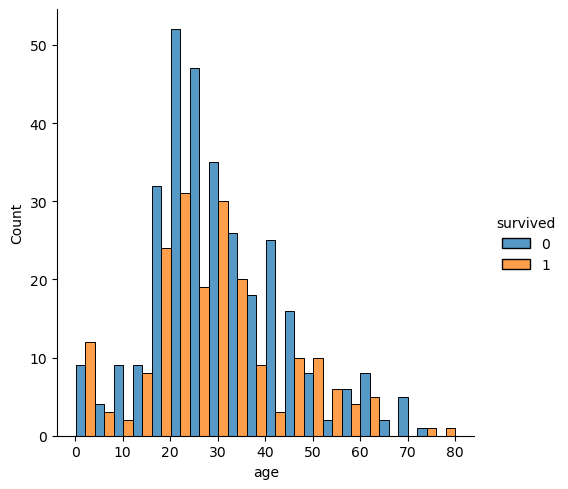

In [110]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)
plt.show()

In [111]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5652173913043478

In [112]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 & c2
train.loc[c]['survived'].mean()

0.16666666666666666

In [113]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3783231083844581

add infant

In [114]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

2 / 
 [0 1] 



((641, 11), (275, 11), (393, 10))

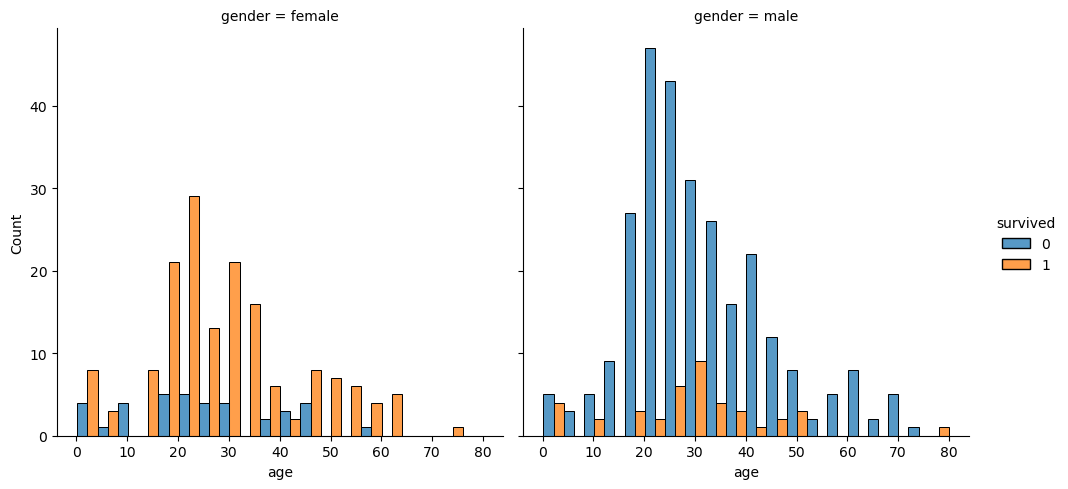

In [115]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")
plt.show()

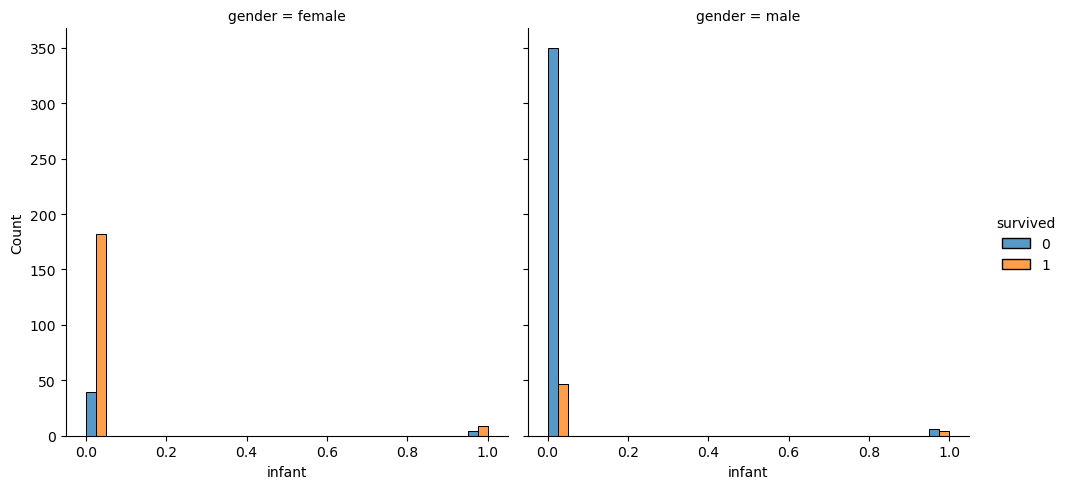

In [116]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")
plt.show()

In [117]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['female_0' 'male_0' 'female_1' 'male_1'] 



((641, 12), (275, 12), (393, 11))

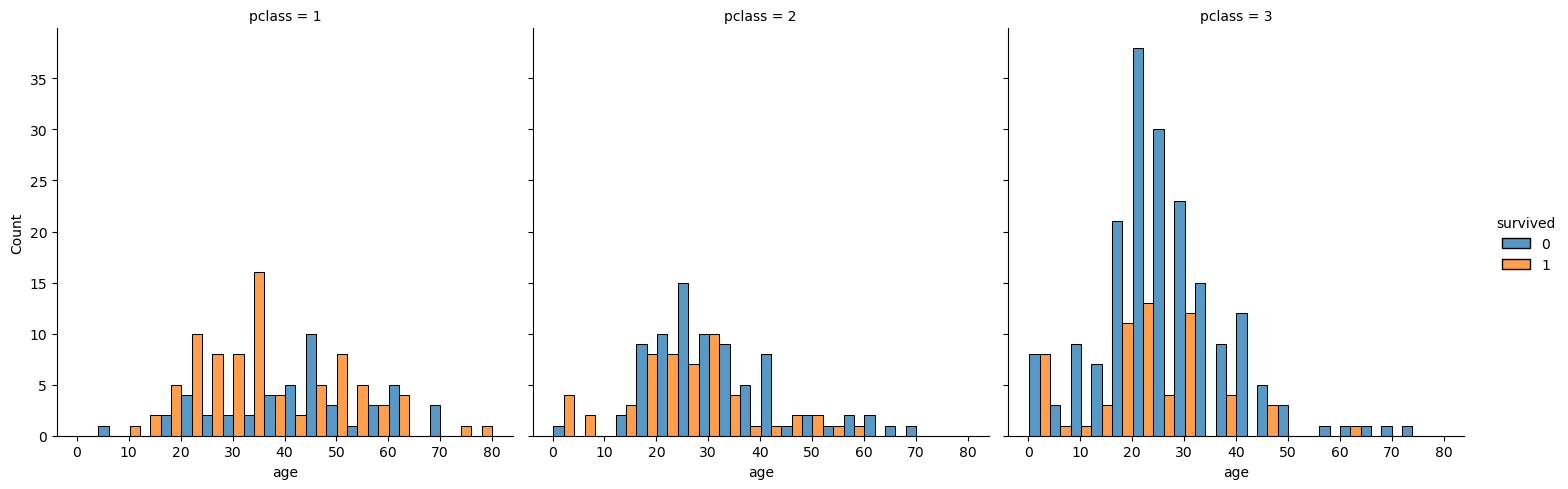

In [118]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")
plt.show()

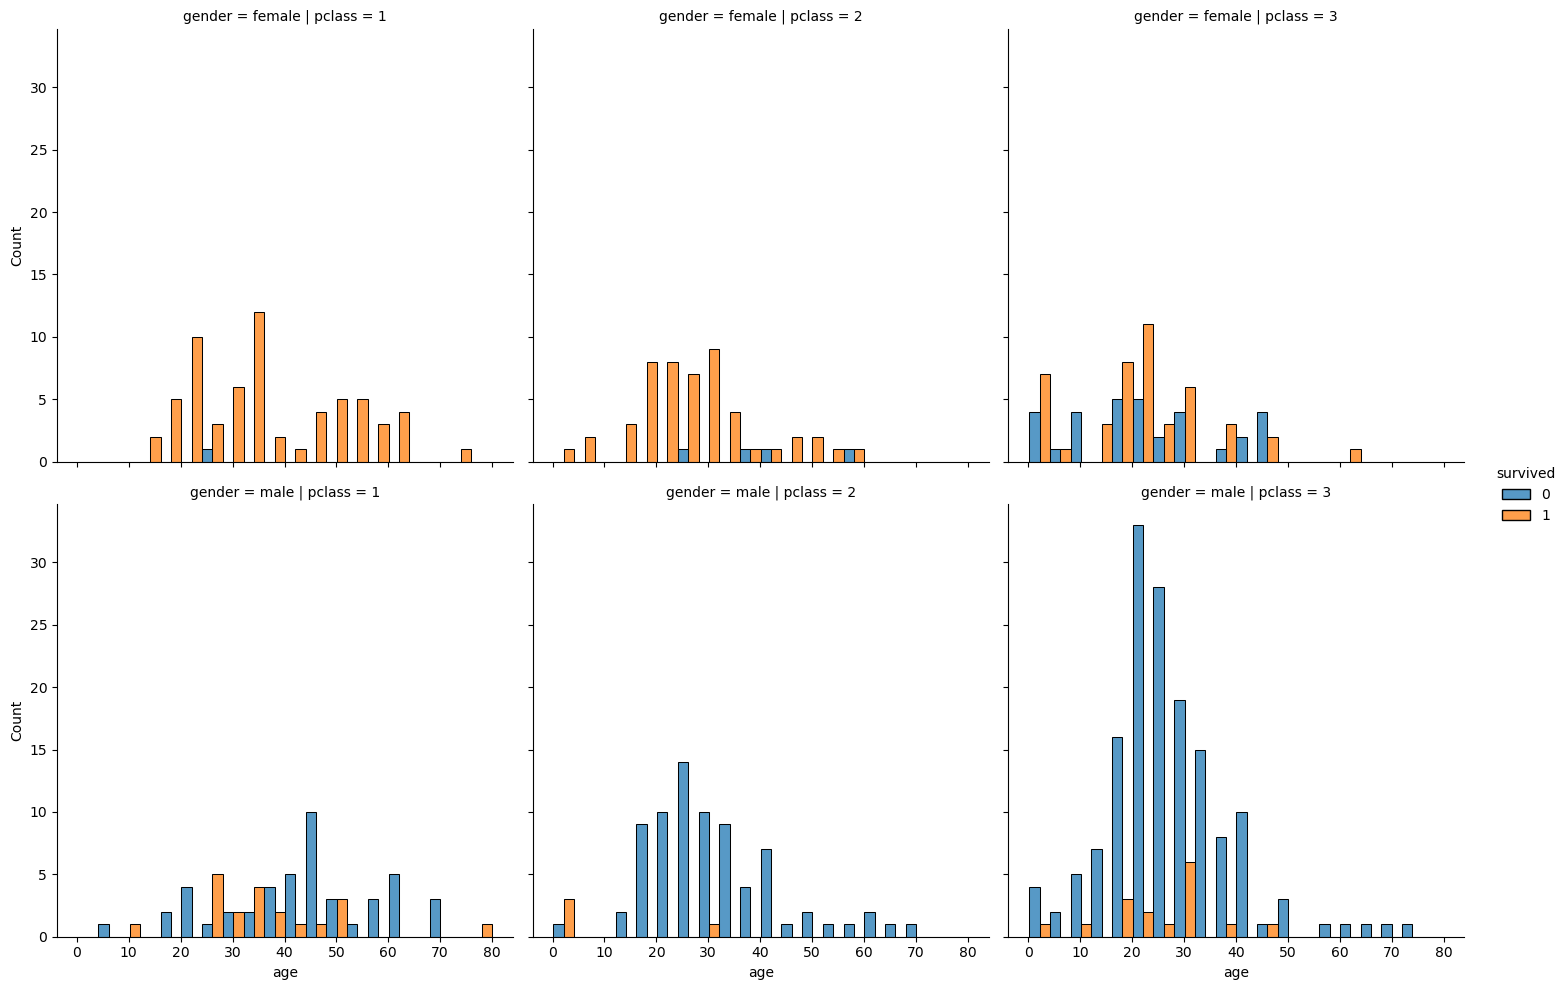

In [119]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')
plt.show()

In [120]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"{train['gender_pclass'].nunique()} / \n {train['gender_pclass'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['female_3' 'male_3' 'female_2' 'male_1' 'female_1' 'male_2'] 



((641, 13), (275, 13), (393, 12))

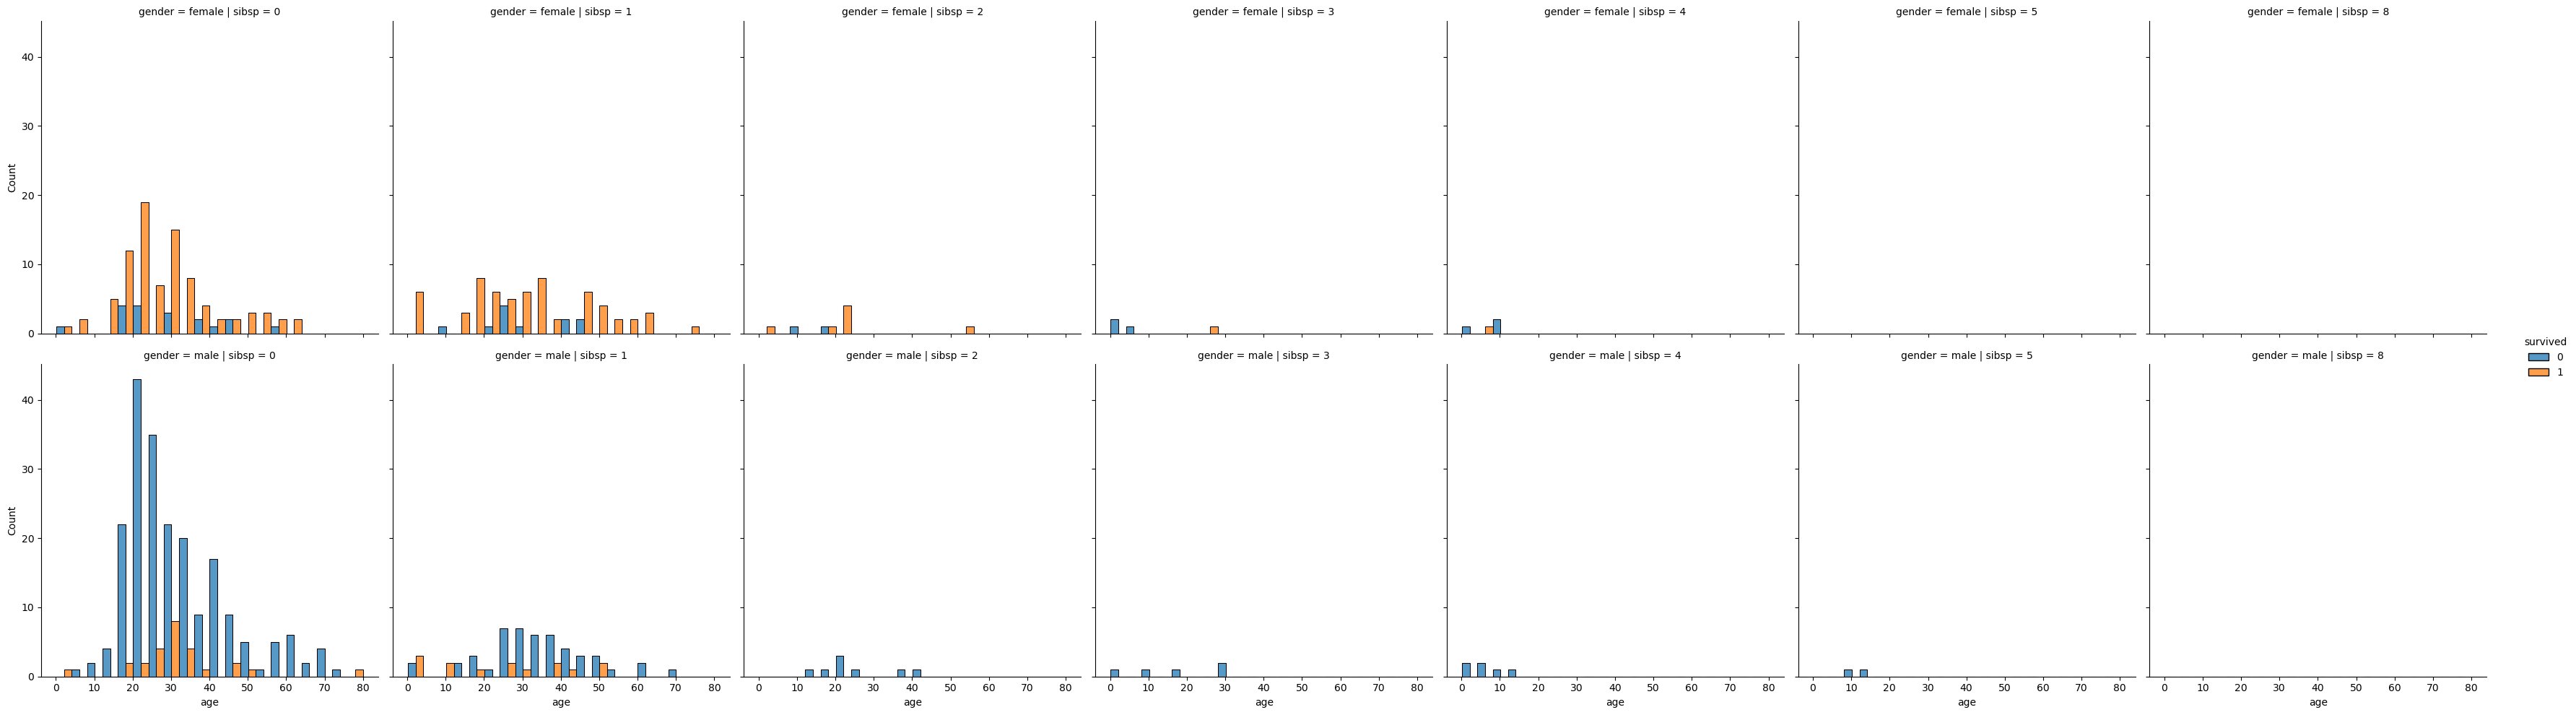

In [121]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')
plt.show()

add gender_sibsp

In [122]:
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass 
  return result 

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"{train['gender_sibsp'].nunique()} / \n {train['gender_sibsp'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['female_0' 'male_0' 'female_2' 'male_1' 'female_1' 'male_2'] 



((641, 14), (275, 14), (393, 13))

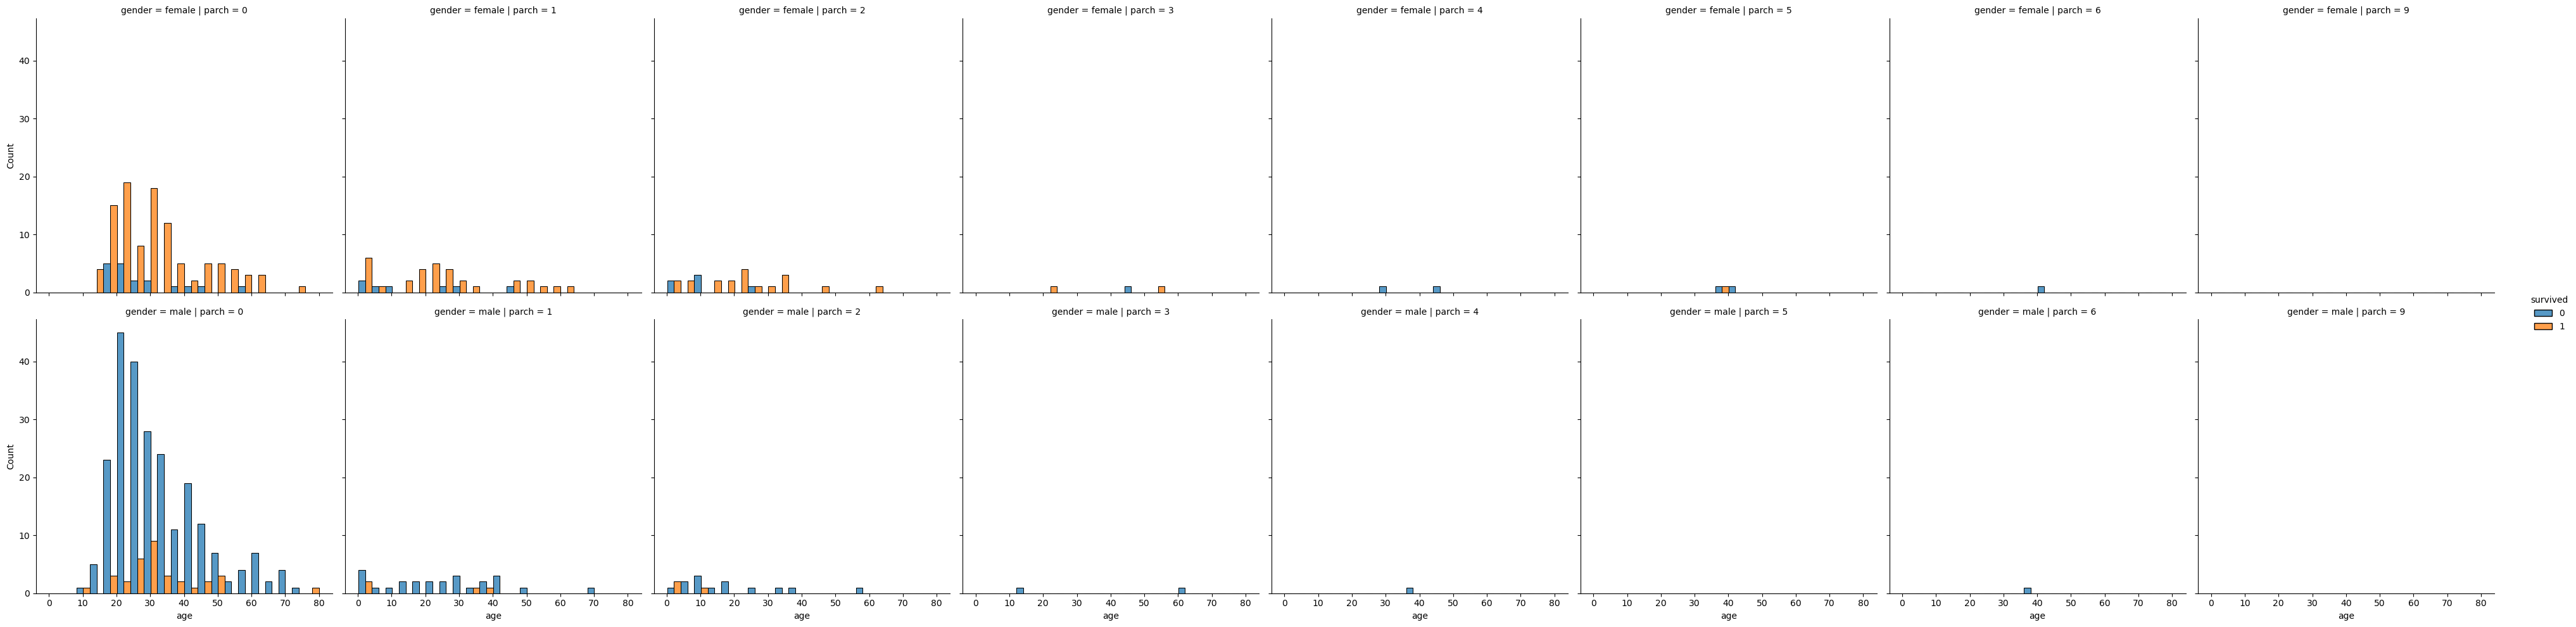

In [123]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')
plt.show()

add gender_parch

In [124]:
train['parch'].unique()

array([0, 3, 2, 1, 5, 9, 4, 6], dtype=int64)

In [125]:
train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"{train['gender_parch'].nunique()} / \n {train['gender_parch'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['female_0' 'male_0' 'female_1' 'male_1'] 



((641, 15), (275, 15), (393, 14))

fare

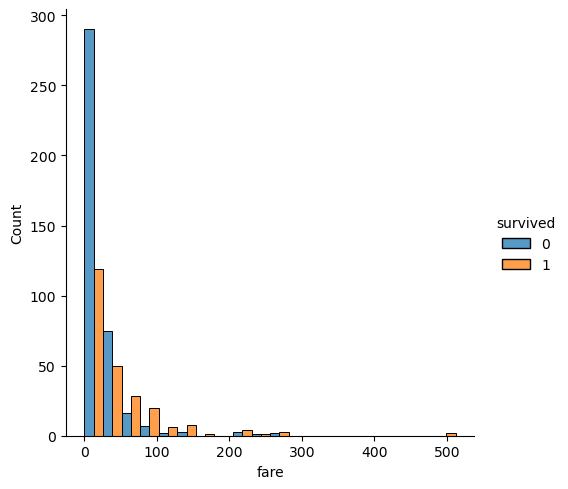

In [126]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)
plt.show()

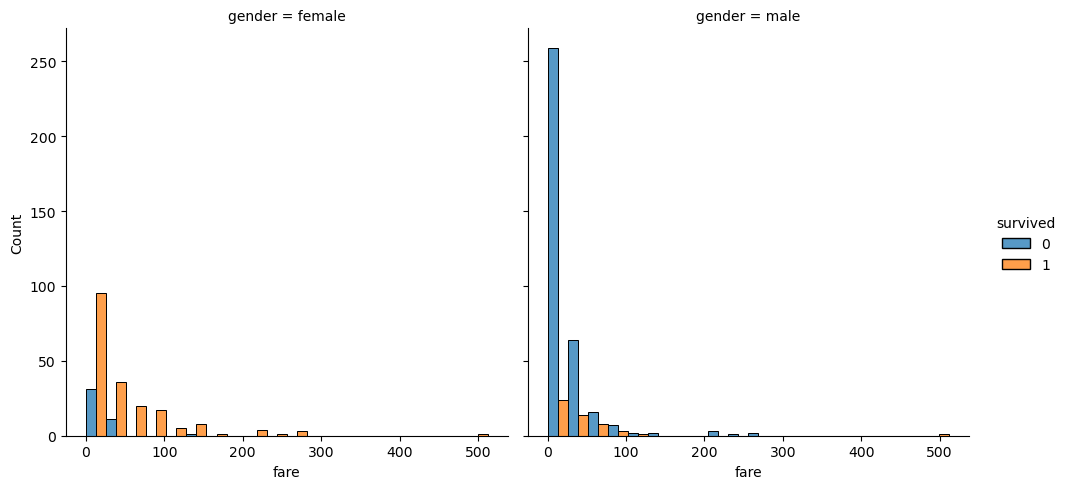

In [127]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")
plt.show()

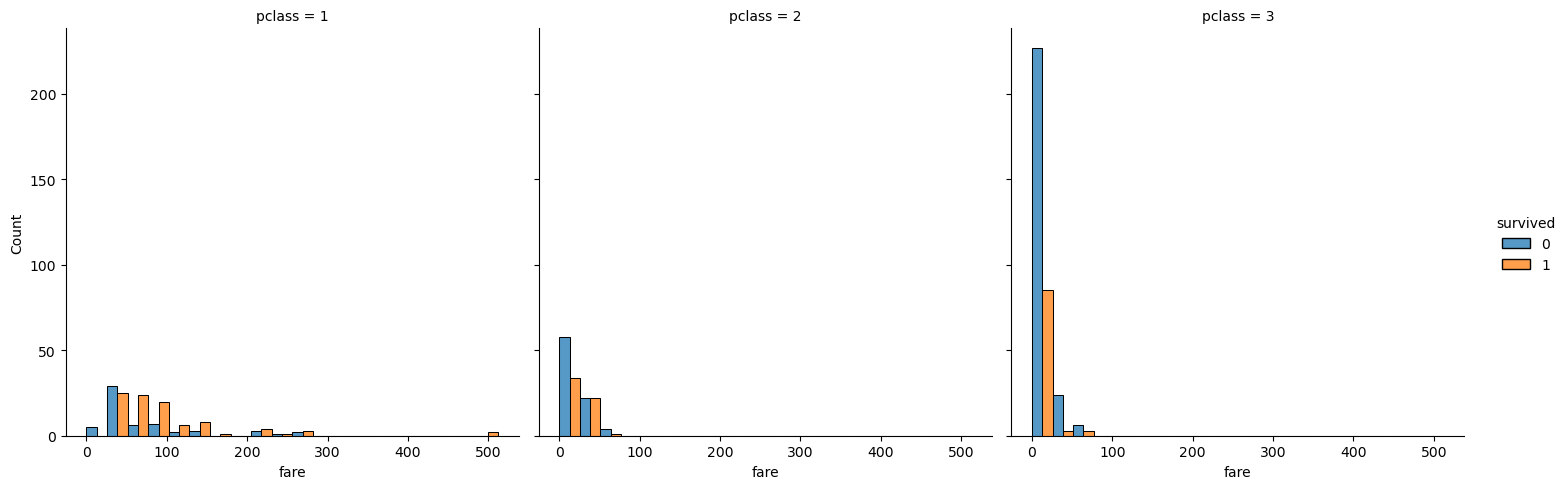

In [128]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")
plt.show()

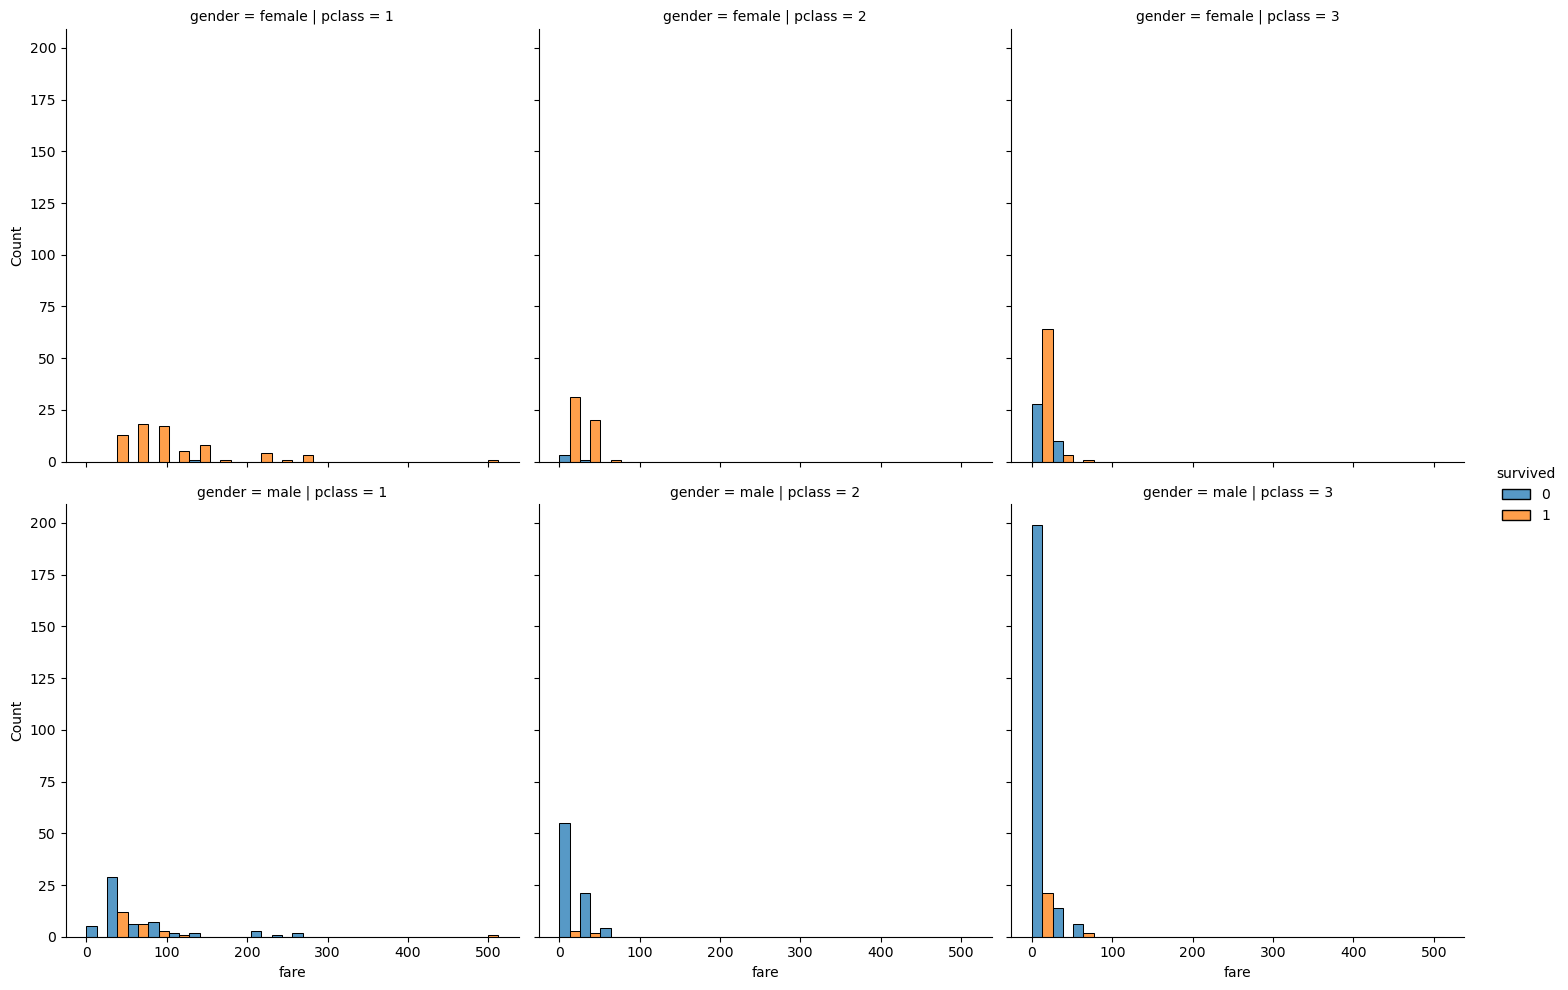

In [129]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')
plt.show()

In [130]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch'],
      dtype='object')

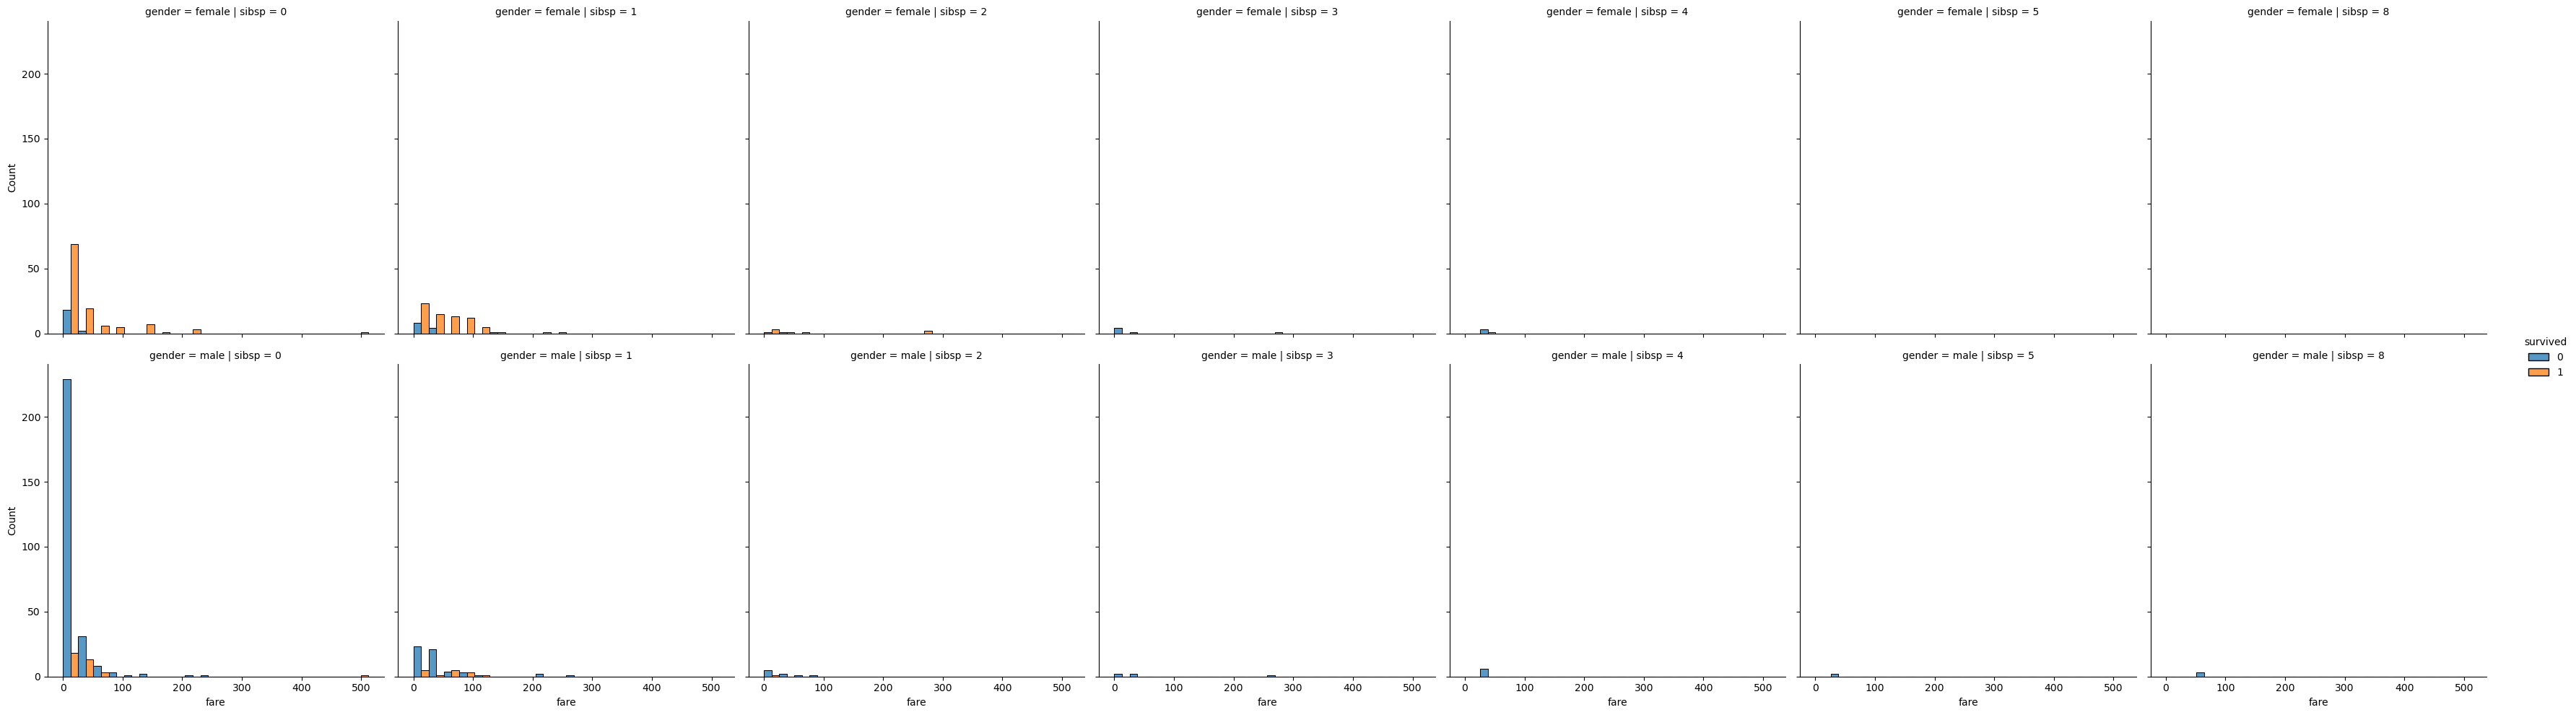

In [131]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')
plt.show()

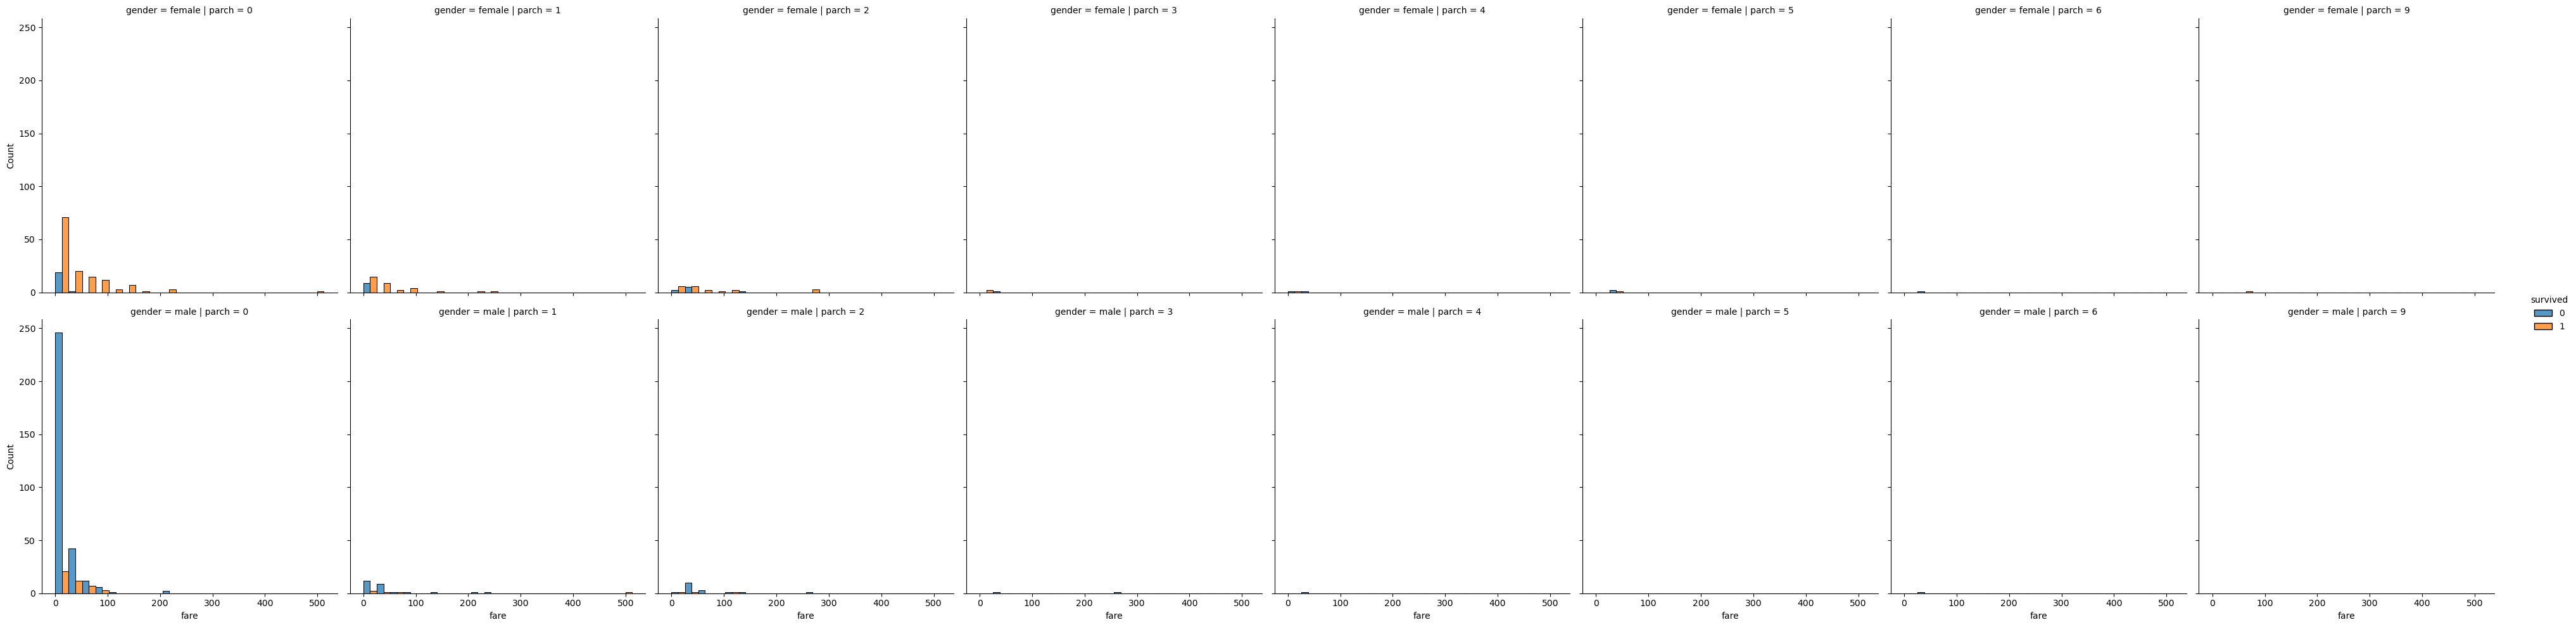

In [132]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')
plt.show()

### ordinal features

In [133]:
ordinal_cols = ['pclass', 'sibsp', 'parch'] + ['survived']

train[ordinal_cols].describe()

,pclass,sibsp,parch,survived
count,641.000000,641.000000,641.000000,641.000000
mean,2.305772,0.466459,0.368175,0.377535
std,0.829221,0.961386,0.897140,0.485149
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000,1.000000
max,3.000000,8.000000,9.000000,1.000000


In [134]:
train[ordinal_cols].corr()

,pclass,sibsp,parch,survived
pclass,1.000000,0.036405,0.039566,-0.299053
sibsp,0.036405,1.000000,0.367602,-0.013008
parch,0.039566,0.367602,1.000000,0.067856
survived,-0.299053,-0.013008,0.067856,1.000000


add reversed_pclass

In [135]:
train['reversed_pclass'] = train['pclass'].map(lambda x: 4 - int(x))  
test['reversed_pclass'] = test['pclass'].map(lambda x: 4 - int(x))  
ori_te['reversed_pclass'] = ori_te['pclass'].map(lambda x: 4 - int(x))  

train[ordinal_cols+['reversed_pclass']].corr()

,pclass,sibsp,parch,survived,reversed_pclass
pclass,1.000000,0.036405,0.039566,-0.299053,-1.000000
sibsp,0.036405,1.000000,0.367602,-0.013008,-0.036405
parch,0.039566,0.367602,1.000000,0.067856,-0.039566
survived,-0.299053,-0.013008,0.067856,1.000000,0.299053
reversed_pclass,-1.000000,-0.036405,-0.039566,0.299053,1.000000


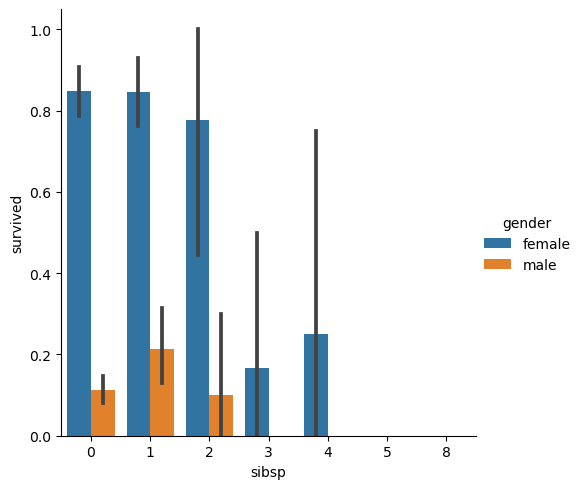

In [136]:
sns.catplot(data=train, x="sibsp", y="survived", hue="gender", kind="bar")
plt.show()

In [137]:
c1 = train['sibsp'] == 8
c2 = train['gender'] == 'female'
c = c1 & c2
train.loc[c]['survived'].mean()

nan

In [138]:
c1 = train['sibsp'] >= 2
c2 = train['gender'] == 'male'
c = c1 & c2
train.loc[c]['survived'].mean()

0.038461538461538464

add sibsp_male

In [139]:
for df in [train, test, ori_te]:
  c1 = df['sibsp'] >= 2
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['sibsp_male'] = c

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 16))

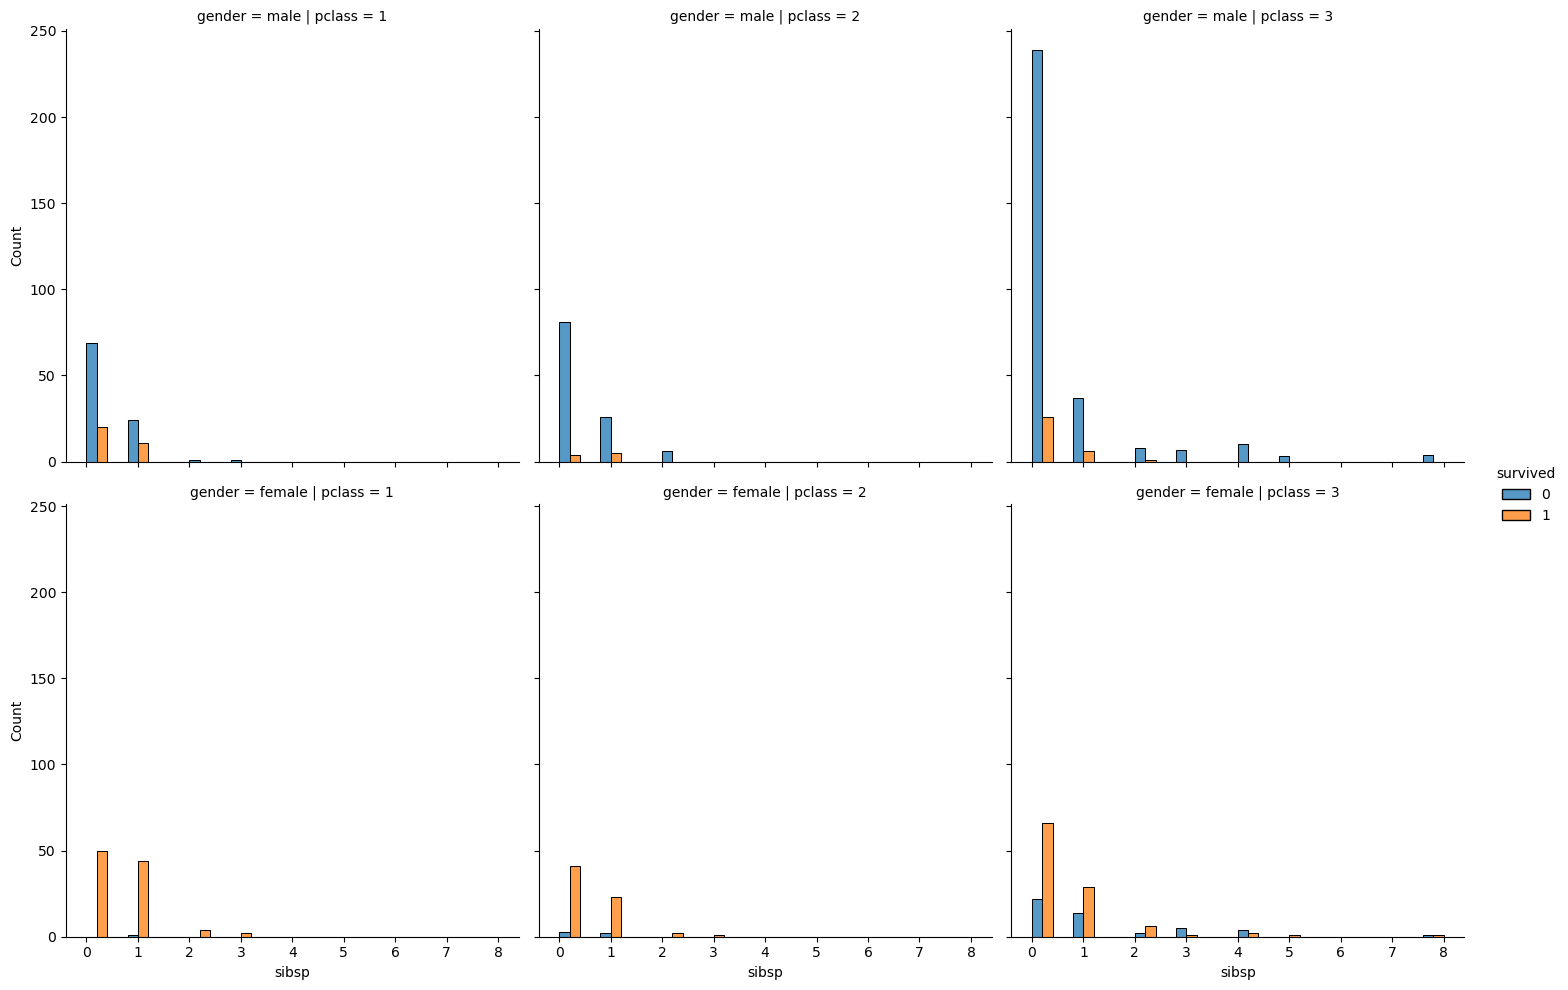

In [140]:
sns.displot(ori_tr, x="sibsp", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')
plt.show()

In [141]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male'],
      dtype='object')

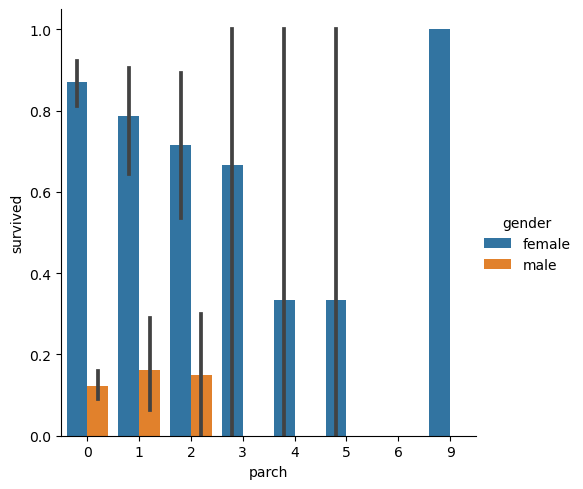

In [142]:
sns.catplot(data=train, x="parch", y="survived", hue="gender", kind="bar")
plt.show()

In [143]:
c1 = train['gender'] == 'male'
c2 = train['parch'] >= 3
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add parch_male

In [144]:
for df in [train, test, ori_te]:
  c1 = df['parch'] >= 3
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['parch_male'] = c

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

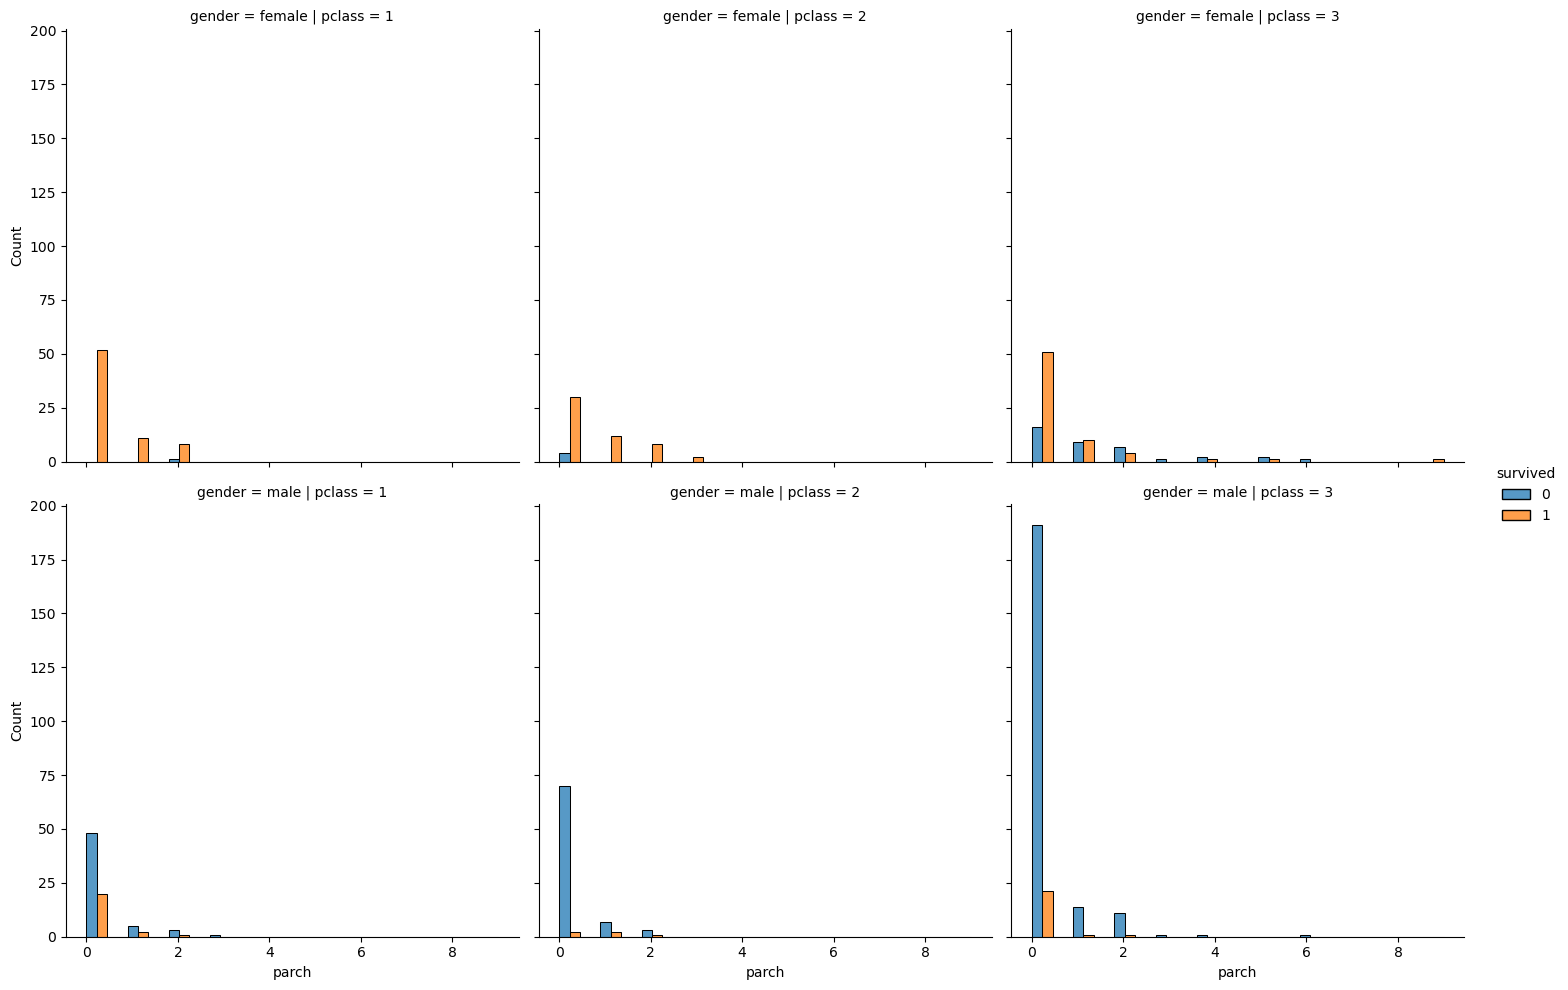

In [145]:
sns.displot(train, x="parch", hue="survived", multiple="dodge", bins=20, col="pclass", row="gender")
plt.show()

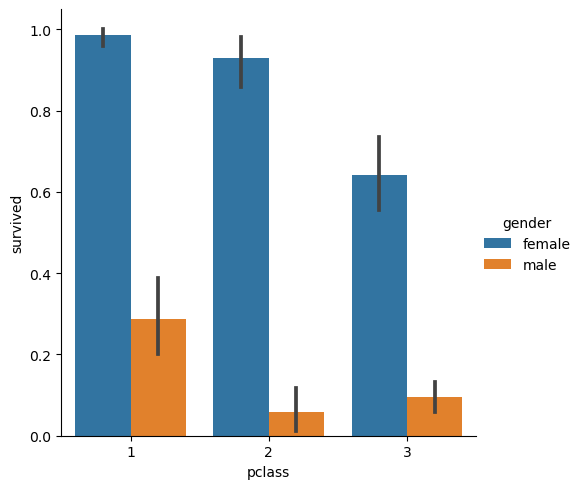

In [146]:
sns.catplot(data=train, x="pclass", y="survived", hue="gender", kind="bar")
plt.show()

### categorical features

In [147]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male', 'parch_male'],
      dtype='object')

In [148]:
categorical_cols = ['gender', 'embarked'] + ['survived']
train[categorical_cols].describe(include='all')

,gender,embarked,survived
count,641,641,641.000000
unique,2,3,NaN
top,male,S,NaN
freq,407,455,NaN
mean,NaN,NaN,0.377535
std,NaN,NaN,0.485149
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


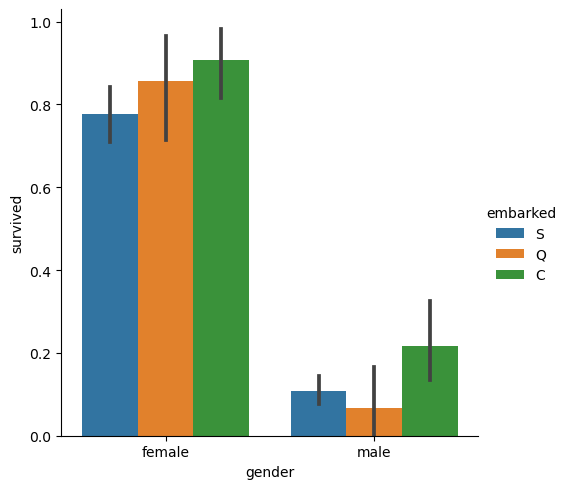

In [149]:
sns.catplot(data=train, x="gender", y="survived", hue="embarked", kind="bar")
plt.show()

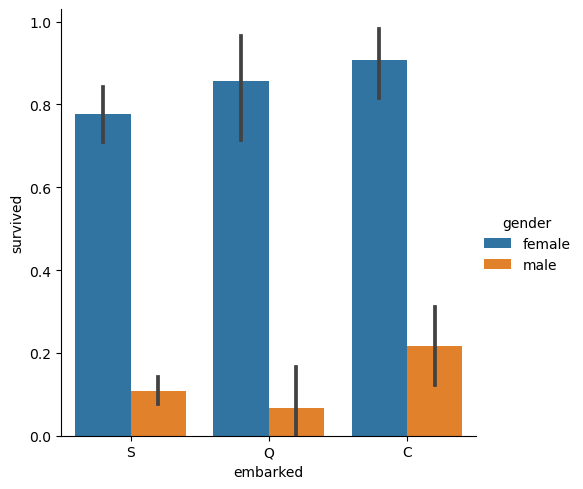

In [150]:
sns.catplot(data=train, x="embarked", y="survived", hue="gender", kind="bar")
plt.show()

### text features

In [151]:
text_cols = ['name', 'ticket']
train[text_cols].head()

,name,ticket
812,"Ohman, Miss. Velin",347085
134,"Buckley, Mr. Daniel",330920
390,"Jonsson, Mr. Carl",350417
305,"Hassan, Mr. Houssein G N",2699
203,"Corn, Mr. Harry",SOTON/OQ 392090


In [152]:
for df in [train, test, ori_te]:
  df['Initial_name'] = df['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
  df.drop(['name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

In [153]:
train['Initial_name'].unique()

array(['Miss', 'Mr', 'Mrs', 'Master', 'Dr', 'Rev', 'Capt', 'Mlle', 'Ms',
       'Col', 'Major', 'Sir', 'Jonkheer'], dtype=object)

In [154]:
train['Initial_name'].value_counts() 

Mr          370
Miss        126
Mrs         106
Master       22
Rev           4
Dr            3
Col           3
Major         2
Capt          1
Mlle          1
Ms            1
Sir           1
Jonkheer      1
Name: Initial_name, dtype: int64

In [155]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}


def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass 
  return result

for df in [train, test, ori_te]:
  df['Initial_name_type'] = df['Initial_name'].map(lambda x: add_initial_name_type(x))
  df.drop(['Initial_name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape


((641, 18), (275, 18), (393, 17))

add len_ticket

In [156]:
for df in [train, test, ori_te]:
  df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
  df.drop(['ticket'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

### datetime features

## Missing Value

In [157]:
(train.isnull() / train.shape[0]).sum().sort_values(ascending=False)

age                  0.201248
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
embarked             0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [158]:
(test.isnull() / test.shape[0]).sum().sort_values(ascending=False)

age                  0.185455
embarked             0.003636
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [159]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

age                  0.211196
fare                 0.002545
embarked             0.002545
pclass               0.000000
gender_sibsp         0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_infant        0.000000
gender_pclass        0.000000
gender               0.000000
infant               0.000000
parch                0.000000
sibsp                0.000000
len_ticket           0.000000
dtype: float64

In [160]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1): 
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')

In [161]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['fare', 'age', 'embarked']
p_train: 0 / p_test: 0 / p_ori_te: 0


## Scaling

In [162]:
from sklearn.preprocessing import StandardScaler

In [163]:
train.columns

Index(['survived', 'pclass', 'gender', 'sibsp', 'parch', 'embarked', 'infant',
       'gender_infant', 'gender_pclass', 'gender_sibsp', 'gender_parch',
       'reversed_pclass', 'sibsp_male', 'parch_male', 'Initial_name_type',
       'len_ticket', 'fare_cleaning', 'age_cleaning'],
      dtype='object')

In [164]:
scaling_cols = ['age_cleaning', 'fare_cleaning']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 18), (275, 18), (393, 17))

## Encoding

In [165]:
from sklearn.preprocessing import OneHotEncoder

In [166]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Initial_name_type  641 non-null    object 
 1   sibsp_male         641 non-null    bool   
 2   gender             641 non-null    object 
 3   gender_pclass      641 non-null    object 
 4   gender_parch       641 non-null    object 
 5   len_ticket         641 non-null    int64  
 6   gender_sibsp       641 non-null    object 
 7   embarked           641 non-null    object 
 8   gender_infant      641 non-null    object 
 9   sibsp              641 non-null    int64  
 10  parch              641 non-null    int64  
 11  infant             641 non-null    int64  
 12  survived           641 non-null    int64  
 13  pclass             641 non-null    int64  
 14  reversed_pclass    641 non-null    int64  
 15  parch_male         641 non-null    bool   
 16  age_cleaning       641 non

In [167]:
for df in [train, test, ori_te]:
  df['sibsp_male'] = df['sibsp_male'].astype("int32")
  df['parch_male'] = df['parch_male'].astype("int32")

In [168]:
train.head()

,Initial_name_type,sibsp_male,gender,gender_pclass,gender_parch,len_ticket,gender_sibsp,embarked,gender_infant,sibsp,parch,infant,survived,pclass,reversed_pclass,parch_male,age_cleaning,fare_cleaning
0,Others,0,female,female_3,female_0,1,female_0,S,female_0,0,0,0,1,3,1,0,-0.603171,-0.479616
1,Others,0,male,male_3,male_0,1,male_0,Q,male_0,0,0,0,0,3,1,0,-0.673082,-0.478696
2,Others,0,male,male_3,male_0,1,male_0,S,male_0,0,0,0,1,3,1,0,0.095941,-0.478025
3,Others,0,male,male_3,male_0,1,male_0,C,male_0,0,0,0,0,3,1,0,-1.372193,-0.258431
4,Others,0,male,male_3,male_0,2,male_0,S,male_0,0,0,0,0,3,1,0,-0.043882,-0.474092


In [169]:
train.select_dtypes(exclude=np.number)

,Initial_name_type,gender,gender_pclass,gender_parch,gender_sibsp,embarked,gender_infant
0,Others,female,female_3,female_0,female_0,S,female_0
1,Others,male,male_3,male_0,male_0,Q,male_0
2,Others,male,male_3,male_0,male_0,S,male_0
3,Others,male,male_3,male_0,male_0,C,male_0
4,Others,male,male_3,male_0,male_0,S,male_0
...,...,...,...,...,...,...,...
636,Others,female,female_2,female_0,female_0,S,female_0
637,Others,female,female_3,female_0,female_0,Q,female_0
638,Others,male,male_1,male_0,male_0,S,male_0
639,Officer,male,male_3,male_1,male_2,S,male_1


In [170]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 7
0 / 0 / 0


((641, 39), (275, 39), (393, 38))

## Modeling

In [171]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [172]:
train.shape, test.shape, ori_te.shape

((641, 39), (275, 39), (393, 38))

In [173]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((641, 38), (641,), (275, 38), (275,))

In [174]:
from sklearn.tree import DecisionTreeClassifier

In [175]:
modelV4 = DecisionTreeClassifier(random_state=args.random_state)

modelV4.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=21)

## Evaluation

In [176]:
score_tr = modelV4.score(X_tr, y_tr)
score_te = modelV4.score(X_te, y_te) 

score_tr, score_te  

(0.9953198127925117, 0.7781818181818182)

In [177]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV4.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7614991003148898


In [178]:
ori_te_pred = modelV4.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [179]:
df_feature_importances = pd.DataFrame(modelV4.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(38, 2)


,index,0
0,gender_female,0.476129
1,age_cleaning,0.207402
2,fare_cleaning,0.128363
3,reversed_pclass,0.039714
4,gender_pclass_male_1,0.017583
5,len_ticket,0.015781
6,embarked_S,0.012904
7,embarked_C,0.012425
8,parch,0.011188
9,sibsp,0.010740


In [180]:
args.results.append(
    {
        'model': 'modelV4',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [181]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.982839,0.774545,0.763580,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
2,modelV2,0.982839,0.778182,0.762427,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217
4,modelV4,0.995320,0.778182,0.761499,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",38,"[gender_female, age_cleaning, fare_cleaning, r...",0220
3,modelV3,0.992200,0.774545,0.750843,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",19,"[gender_female, age_cleaning, fare_cleaning, p...",0220
1,modelV1,0.982839,0.785455,0.495192,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217


# Submission

In [182]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.982839,0.774545,0.763580,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
2,modelV2,0.982839,0.778182,0.762427,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.125, 1.0...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217
4,modelV4,0.995320,0.778182,0.761499,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",38,"[gender_female, age_cleaning, fare_cleaning, r...",0220
3,modelV3,0.992200,0.774545,0.750843,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",19,"[gender_female, age_cleaning, fare_cleaning, p...",0220
1,modelV1,0.982839,0.785455,0.495192,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10,"[gender_male, fare, age, pclass, sibsp, embark...",0217


In [183]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [184]:
submission['survived'] = df_results.loc[3, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.0
1,917,1.0
2,918,1.0
3,919,1.0
4,920,1.0
5,921,1.0
6,922,0.0
7,923,1.0
8,924,0.0
9,925,0.0


In [185]:
submission.to_csv(args.default_path+'result/submission_v3.csv', header=True, index=False)

In [186]:
submission['survived'] = df_results.loc[4, ['ori_te_pred']].values[0]
submission.to_csv(args.default_path+'result/submission_v4.csv', header=True, index=False)

# Save Results

In [187]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 
df_results

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV0,0.982839,0.774545,0.763580,10,"[gender_female, fare, age, pclass, sibsp, emba...",0217
2,modelV2,0.982839,0.778182,0.762427,10,"[gender_male, fare, age, pclass, sibsp, embark...",0217
4,modelV4,0.995320,0.778182,0.761499,38,"[gender_female, age_cleaning, fare_cleaning, r...",0220
3,modelV3,0.992200,0.774545,0.750843,19,"[gender_female, age_cleaning, fare_cleaning, p...",0220
1,modelV1,0.982839,0.785455,0.495192,10,"[gender_male, fare, age, pclass, sibsp, embark...",0217


In [188]:
df_results.to_json(args.save_results, orient="records")

In [189]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

len(load_results)

5